In [9]:
#task 1

In [10]:
import pandas as pd
import numpy as np

In [11]:
df = pd.read_csv("./mushrooms.csv").drop_duplicates().dropna()

In [12]:
#task2

In [13]:
n = int(np.sqrt(df.shape[1]))

In [14]:
x = pd.get_dummies(df.drop(columns=["class"]).sample(n ,axis=1)).astype(float).values
y = df["class"].map({'e': 0, 'p': 1}).values

In [15]:
#task3

In [16]:
from collections import Counter
import numpy as np

def entropy(x):
  _, counts = np.unique(x, return_counts=True)
  return -((counts / x.shape[0]) * np.log2(counts / x.shape[0])).sum()

class DisicionTree:
  def __init__(self, max_depth=3):
    self.max_depth = max_depth

# info gain
  def ig(self, y, y_left, y_right):
    return entropy(y) - (len(y_left) * entropy(y_left) + len(y_right) * entropy(y_right)) / len(y)

  def fit(self, x: np.array, y: np.array):
    self.x, self.y =x, y
    self.tree = self.Tree(self.max_depth, self).fit(self.x, self.y)
    return self

  def classify(self, x):
    return self.tree.classify(x)

  def predict_proba(self, x):
    return np.array([self.predict_probax_i(x_i) for x_i in x])

  def predict_probax_i(self, x):
    return self.tree.predict_proba(x)

  def predict(self, x):
    return np.array([self.classify(x_i) for x_i in x])

  class Tree:
    def __init__(self, max_depth, main_tree):
      self.max_depth = max_depth
      self.main_tree = main_tree


    def ig_wrapper(self, leaf, feature, condition):
      index = leaf.x[:,feature] < condition
      return self.main_tree.ig(leaf.y, leaf.y[index], leaf.y[~index]), condition, leaf, feature


    def fit(self, x: np.array, y: np.array):
      self.root = DisicionTree.Leaf(x, y, 0, None)
      self.leafs = [self.root]

      while len(self.leafs) != 0:
        ig, condition, leaf, feature = self.best_feature(max(self.leafs, key=lambda leaf: leaf.loss))#self.best_leaf_split()
        node = DisicionTree.Node(leaf.x, leaf.y, feature, condition, leaf.depth)

        if leaf.parent is None:
          self.root = node
        else:
          if leaf.parent.left is leaf:
            leaf.parent.left = node

          if leaf.parent.right is leaf:
            leaf.parent.right = node

        self.leafs.remove(leaf)
        if leaf.depth  != self.max_depth - 1:
          if node.left.loss > 0:
            self.leafs.append(node.left)
          if node.right.loss > 0:
            self.leafs.append(node.right)
      return self

    def classify(self, x):
      return self.root.classify(x)

    def predict_proba(self, x):
      return self.root.predict_proba(x)

    def best_leaf_split(self):
      return max(self.leafs, key=lambda leaf: leaf.loss)
      #return max(self.best_feature(leaf) for leaf in self.leafs)


    def best_feature(self, leaf):
      return max(self.best_condition(leaf, feature) for feature in range(leaf.x.shape[1]))

    def best_condition(self, leaf, feature):
      sortedx = np.sort(leaf.x[:, feature])
      conditions = (sortedx[1:] + sortedx[:-1]) / 2
      return max(self.ig_wrapper(leaf, feature, np.random.choice(conditions)) for _ in range(5))

  class Node:
    def __init__(self, x, y, feature, condition, depth):
      self.condition, self.feature, self.depth = condition, feature, depth
      index = x[:, feature] < condition
      self.left = DisicionTree.Leaf(x[index], y[index], self.depth, self)
      self.right = DisicionTree.Leaf(x[~index], y[~index], self.depth, self)

    def classify(self, x):
      return self.left.classify(x) if x[self.feature] < self.condition else self.right.classify(x)

    def predict_proba(self, x):
      return self.left.predict_proba(x) if x[self.feature] < self.condition else self.right.predict_proba(x)

  class Leaf:
    def __init__(self, x, y, depth, parent):
      self.loss = entropy(y)
      self.depth = depth + 1
      self.x, self.y = x, y
      self.parent = parent
      tmp = np.array(Counter(y).most_common(2))
      if len(x) > 0:
        total = np.sum(tmp[:, 1])
      self.freq = {c : k / total for c, k in tmp}

    def classify(self, x):
      return max(self.freq, key=self.freq.get)

    def predict_proba(self, x):
      return np.array([self.freq.get(0, 0), self.freq.get(1, 0)])

  def statistics(self, x, y):
      out = self.predict(x)
      outputs = {'False': 1, 'True': 0}
      tp, tn, fp, fn = 0, 0, 0, 0
      for out_i, y_i in zip(out, y):
        if out_i == outputs['True']:
          if y_i == outputs['True']:
            tp += 1
          else:
            fp += 1
        else:
          if y_i == outputs['True']:
            fn += 1
          else:
            tn += 1
      return {'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn}

  def FPR(self, x, y):
    stats = self.statistics(x, y)
    return stats['FP'] / (stats['FP'] + stats['TN'])

  def score(self, x, y):
    stats = self.statistics(x, y)
    return (stats['TP'] + stats['TN']) / (stats['TP'] + stats['TN'] + stats['FP'] + stats['FN'])

  def accuracy(self, x, y):
    stats = self.statistics(x, y)
    return (stats['TP'] + stats['TN']) / (stats['TP'] + stats['TN'] + stats['FP'] + stats['FN'])

  def precision(self, x, y):
    stats = self.statistics(x, y)
    return stats['TP'] / (stats['TP'] + stats['FP'])

  def recall(self, x, y):
    stats = self.statistics(x, y)
    return stats['TP'] / (stats['TP'] + stats['FN'])

  def f1_score(self, x, y):
    precision = self.precision(x, y)
    recall = self.recall(x, y)
    return 2 * (precision * recall) / (precision + recall)

  def confusion_matrix(self, x, y):
    stats = self.statistics(x, y)
    return np.array([[stats['TN'], stats['FP']], [stats['FN'], stats['TP']]])




In [17]:
#task 4

In [18]:
tree = DisicionTree(max_depth=7).fit(x, y)

In [19]:
print(tree.accuracy(x, y))
print(tree.precision(x, y))
print(tree.recall(x, y))

0.8759231905465288
0.911522633744856
0.8422053231939164


In [20]:
#task4

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_roc(y_true, y_pred_prob):
    thresholds = np.arange(0.0, 1.1, 0.01)
    fpr = []
    tpr = []

    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)

        tp = np.sum((y_true == 1) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
        tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

    return np.array(fpr), np.array(tpr), thresholds

def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, thresholds = calculate_roc(y_true, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


/var/folders/pl/zhkjndkn2k169_3t63dgk06m0000gn/T/ipykernel_7444/2535941519.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


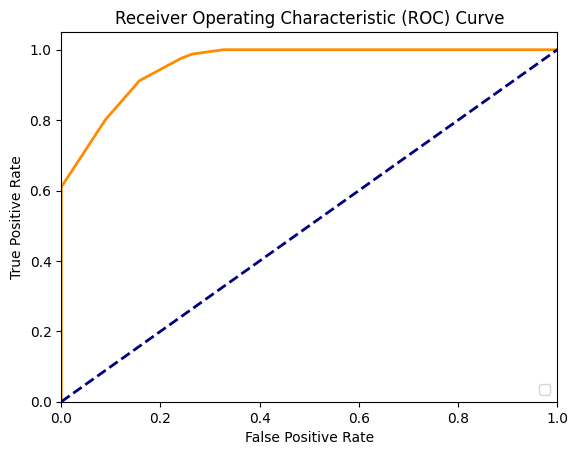

In [22]:
predict_proba = tree.predict_proba(x)[:, 1]
plot_roc_curve(y, predict_proba)

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def precision_recall_curve_manual(y_true, predict_proba):
    thresholds = np.sort(predict_proba)[::-1]

    precision = []
    recall = []
    for threshold in thresholds:
        y_pred = (predict_proba >= threshold).astype(int)

        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        p = tp / (tp + fp) if tp + fp > 0 else 0
        r = tp / (tp + fn) if tp + fn > 0 else 0

        precision.append(p)
        recall.append(r)

    return np.array(precision), np.array(recall), thresholds

def plot_auc_pr_curve(y_true, predict_proba):
    precision, recall, _ = precision_recall_curve_manual(y_true, predict_proba)


    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

/var/folders/pl/zhkjndkn2k169_3t63dgk06m0000gn/T/ipykernel_7444/303880276.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


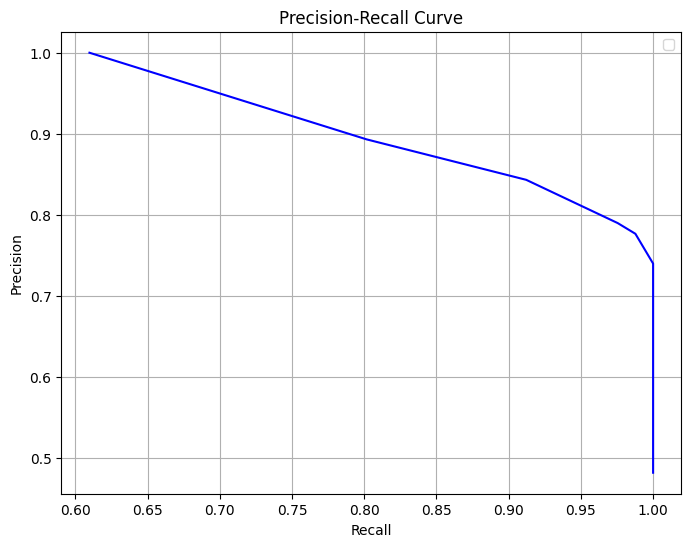

In [24]:
plot_auc_pr_curve(y, predict_proba)